In [1]:
import sys 
sys.path.append('../')
from IPython.display import display
import pandas as pd 
import pickle
import os 
import re 
import pickle

from utils.env import EvoD4jEnv
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
def convert_docker_to_local_path(path):
    path  = path.replace("/root/workspace","/home/coinse/Workspace/autooracle/workspace")
    return path

def convert_to_prompt_path(chat_reply_file_path):
    if "chat_reply_mut" in chat_reply_file_path:
        chat_reply_file_path = chat_reply_file_path.replace("chat_reply_mut", "prompt")
    else:
        chat_reply_file_path = chat_reply_file_path.replace("chat_reply", "prompt")
    prompt_path = chat_reply_file_path.split('/')
    del prompt_path[-2]
    if prompt_path[-1].endswith("reply.txt"):
        prompt_path[-1] = prompt_path[-1].replace("reply.txt","query.txt")
    prompt_path = '/'.join(prompt_path)
    return prompt_path

def extract_label(path):
    with open(path, 'r') as file:
        file_content = file.read()
    lines = file_content.split('\n')
    for line in reversed(lines):
        if 'undecidable' in line.lower():
            return 'undecidable'
        elif 'incorrect' in line.lower():
            return 'incorrect'
        elif 'correct' in line.lower():
            return 'correct'
        else:
            pass
    # If no label is found, return None
    return "None"

def get_docmumet_length(prompt_path):
    with open(prompt_path,'r') as f:
        prompt = f.readlines()
    document = ''
    isdocument=False
    for line in prompt:
        if line.find("signature:") != -1:
            isdocument = True
            continue
        if isdocument:
            if line.find("```") != -1:
                isdocument= False
                continue
            document += line.strip()
        if not isdocument and len(document) > 0:
            break
    return len(document)

def process_test_info(file_name, chat_reply_file_path):
    test_infos = file_name.split('_')
    test_class = test_infos[0]
    test_no = test_infos[1]
    oracle_type = test_infos[2]
    document_length = get_docmumet_length(convert_to_prompt_path(chat_reply_file_path))
    return test_class, test_no, oracle_type, document_length

def get_idx_chat_reply_result(project, version, idx, ts_id, prompt_no, example_num, is_conv):
    env = EvoD4jEnv(project, version, idx, ts_id)
    chat_reply_org_root_path = convert_docker_to_local_path(os.path.join(env.evosuite_chat_reply_dir, f'prompt{prompt_no}', f'example{example_num}'))
    chat_reply_trs_root_path = convert_docker_to_local_path(os.path.join(env.evosuite_chat_reply_transform_dir, f'prompt{prompt_no}', f'example{example_num}'))

    idx_test_info = {} # key: test_no, value : [(result1 info), result2, result3, result4, result5]
    idx_test_result = {} # 
    for root_path in [chat_reply_org_root_path, chat_reply_trs_root_path]:
        for try_no in range(1, 6):
            chat_reply_path = os.path.join(root_path, f'try{try_no}')
            for file_name in os.listdir(chat_reply_path):
                if is_conv and file_name.endswith("1"):
                    continue
                chat_reply_file_path = os.path.join(chat_reply_path, file_name)
                label = extract_label(chat_reply_file_path)
                test_class, test_no, oracle_type, document_length = process_test_info(file_name, chat_reply_file_path)
                idx_test_result.setdefault(test_no, []).append(label)
                idx_test_info.setdefault(test_no, [test_class, oracle_type, document_length])

    return idx_test_info, idx_test_result

def all_chat_reply_result(project, version, ts_id, prompt_no, example_no, is_conv):
    with open(f'/home/coinse/Workspace/autooracle/workspace/src/select_dataset/{project}_tests_part1.pkl',"rb") as fw:
        dataset_info = pickle.load(fw)
    print(len(dataset_info))
    all_fail_idx_test_info = {}
    all_fail_idx_test_result = {}
    all_pass_idx_test_info = {}
    all_pass_idx_test_result = {}
    for idx, [fail_tests, pass_tests] in dataset_info.items():
        idx_test_info, idx_test_result = get_idx_chat_reply_result(project, version, str(idx), ts_id, prompt_no, example_no, is_conv)
        
        fail_test_info = {test_no: info for test_no, info in idx_test_info.items() if test_no in fail_tests}
        fail_test_result = {test_no: label for test_no, label in idx_test_result.items() if test_no in fail_tests}

        pass_test_info = {test_no: info for test_no, info in idx_test_info.items() if test_no in pass_tests}
        pass_test_result = {test_no: label for test_no, label in idx_test_result.items() if test_no in pass_tests}
 
        all_fail_idx_test_info[idx] = fail_test_info
        all_fail_idx_test_result[idx] = fail_test_result
        all_pass_idx_test_info[idx] = pass_test_info
        all_pass_idx_test_result[idx] = pass_test_result
    return all_fail_idx_test_info, all_fail_idx_test_result, all_pass_idx_test_info, all_pass_idx_test_result

def process_test_info_df(info_dict, result_dict, sample_num, gt_label):
    df_rows = []
    for idx, tests_dict in info_dict.items():
        for test_no, info_list in tests_dict.items():
            df_rows.append({
                'project': 'Math',
                'version': '1',
                'idx': idx,
                'ts_id': 'newTS_300',
                'test_no': test_no,
                'test_class': info_list[0],
                'type': info_list[1],
                'document_length': info_list[2],
                'ground_truth': gt_label,
                'attempt_org': result_dict[idx][test_no][:sample_num],
                'attempt_trs': result_dict[idx][test_no][5: 5 + sample_num]
            })
    return pd.DataFrame(df_rows)

def score_org(attempt_list):
    score = 0
    for reply in attempt_list:
        if reply == "correct":
            score += 1
        elif reply == "incorrect":
            score -= 1
        elif reply == "undecidable":
            score += 0
        else: 
            score += 0
    return score

def score_trs(attempt_list):
    score = 0
    for reply in attempt_list:
        if reply == "correct":
            score -= 1
        elif reply == "incorrect":
            score += 1
        elif reply == "undecidable":
            score += 0
        else: 
            score += 0
    return score

## Fail tests, Pass tests Dataframe

In [3]:
def get_fail_pass_df(project, version, ts_id, prompt_no, example_no, sample_num, is_conv = False):
    fail_info, fail_result, pass_info, pass_result = all_chat_reply_result(project, version, ts_id, prompt_no, example_no, is_conv)
    # Create DataFrames for fail and pass results
    fail_df = process_test_info_df(fail_info, fail_result, sample_num, "incorrect")
    pass_df = process_test_info_df(pass_info, pass_result, sample_num, "correct")

    fail_df["score_org"] = fail_df["attempt_org"].apply(score_org)
    fail_df["score_trs"] = fail_df["attempt_trs"].apply(score_trs)
    fail_df["score"] = fail_df["score_org"] + fail_df["score_trs"]

    pass_df["score_org"] = pass_df["attempt_org"].apply(score_org)
    pass_df["score_trs"] = pass_df["attempt_trs"].apply(score_trs)
    pass_df["score"] = pass_df["score_org"] + pass_df["score_trs"]
    return fail_df, pass_df

# For DATA ANALYSYS

In [4]:
import matplotlib.pyplot as plt
from IPython.display import Image
from collections import Counter
import seaborn as sns
import numpy as np

def plot_countplot(ax, data, x, color):
    a = sns.countplot(data=data, x=x, color=color)
    plot_sum = 0
    for p in a.patches:
        height = p.get_height()
        plot_sum += height
    for p in a.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)
        #ax.annotate(f'{height/plot_sum * 100:.2f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)
    ax.set_xlabel("Predict", fontsize=10)
    ax.set_ylabel("number of test", fontsize=10)

def count_plot(fail_df, pass_df):
    plt.figure(figsize=(12, 8))

    # Original Plots
    plt.subplot(2, 3, 1)
    plt.title("Original_fail", fontdict={'fontsize': 10})
    plot_countplot(plt.gca(), fail_df, "score_org", '#4BC6CC')

    plt.subplot(2, 3, 4)
    plt.title("Original_pass", fontdict={'fontsize': 10})
    plot_countplot(plt.gca(), pass_df, "score_org", '#4BC6CC')

    # Transformed Plots
    plt.subplot(2, 3, 2)
    plt.title("Transformed_fail", fontdict={'fontsize': 10})
    plot_countplot(plt.gca(), fail_df, "score_trs", '#FF6E3E')

    plt.subplot(2, 3, 5)
    plt.title("Transformed_pass", fontdict={'fontsize': 10})
    plot_countplot(plt.gca(), pass_df, "score_trs", '#FF6E3E')
    # Sum Plots
    fail_df["score"] = fail_df["score_org"] + fail_df["score_trs"]
    plt.subplot(2, 3, 3)
    plt.title("Sum[Incorrect Oracle]", fontdict={'fontsize': 10})
    plot_countplot(plt.gca(), fail_df, "score", 'dodgerblue')

    pass_df["score"] = pass_df["score_org"] + pass_df["score_trs"]
    plt.subplot(2, 3, 6)
    plt.title("Sum[Correct Oracle]", fontdict={'fontsize': 10})
    plot_countplot(plt.gca(), pass_df, "score", 'dodgerblue')

    plt.tight_layout()
    plt.show()

def hist_plot(fail_df, pass_df):
    fail_df["ground_truth"] = "incorrect"
    pass_df["ground_truth"] = "correct"
    pred_df = pd.concat([fail_df, pass_df])
    sns.histplot(data=pred_df, x="score", hue="ground_truth", multiple="dodge")
    plt.yscale("log")

def accumulate_incorrect_ratio_graph(pred_df):
    prediction_columns = ["score", "score_org", "score_trs"]
    plt.figure(figsize=(13, 5))
    for i, col in enumerate(prediction_columns):
        # plt.subplot(1, len(prediction_columns), i+1)
        thresholds = range(pred_df[col].min(), pred_df[col].max() +1)
        incorrect_ratio = [(pred_df[pred_df[col] <= score].ground_truth == "incorrect").mean() for score in thresholds]
        scores = [ 2 * th /(max(thresholds) - min(thresholds)) for th in thresholds]
        # #scores = [ th for th in thresholds]
        plt.plot(scores, incorrect_ratio, marker=".", label=col)

    plt.hlines((pred_df.ground_truth == "incorrect").mean(), min(scores), max(scores), color="red", label="% incorrect tests")
    plt.xlabel("th")
    plt.ylabel("% incorrect tests with score <= th")
    plt.legend()
    plt.ylim((-0.05, 1.05))
    plt.show()
    
def incorrect_ratio_graph(fail_df, pass_df, pred_df):
    prediction_columns = ["score", "score_org", "score_trs"]
    number_of_test_df = pd.DataFrame()
    plt.figure(figsize=(13, 5))
    for i, col in enumerate(prediction_columns):
        number_of_test_df[f'{col}_failing_test'] = fail_df[col].value_counts()
        number_of_test_df[f'{col}_passing_test'] = pass_df[col].value_counts()
        number_of_test_df.fillna(0, inplace=True)
        thresholds = range(pred_df[col].min(), pred_df[col].max() +1)
        failing_ratio =  [number_of_test_df.loc[score, f'{col}_failing_test'] / (number_of_test_df.loc[score, f'{col}_failing_test'] + number_of_test_df.loc[score, f'{col}_passing_test']) for score in thresholds]
        scores = [ 2 * th /(max(thresholds) - min(thresholds)) for th in thresholds]
        plt.plot(scores, failing_ratio, marker=".", label=col)
        
    plt.hlines((pred_df.ground_truth == "incorrect").mean(), min(scores), max(scores), color="red", label="% incorrect tests")
    plt.xlabel("score")
    plt.ylabel("% incorrect tests with score")
    plt.legend()
    plt.show()


def precision_heatmap(pred_df):
    rat_rows_precision = []
    for org_score in range(-5, 6):
        for trs_score in range(-5, 6):
            # True Positives (TP): Ground truth is "incorrect" and predicted as "incorrect"
            TP = ((pred_df.score_org <= org_score) & (pred_df.score_trs <= trs_score) & (pred_df.ground_truth == "incorrect")).sum()
            # False Positives (FP): Ground truth is "correct" but predicted as "incorrect"
            FP = ((pred_df.score_org <= org_score) & (pred_df.score_trs <= trs_score) & (pred_df.ground_truth == "correct")).sum()
            # Calculate precision
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            rat_rows_precision.append((org_score, trs_score, precision))

    # Create precision dataframe and heatmap
    plt.figure(figsize=(10, 10))
    rat_df_precision = pd.DataFrame(data=rat_rows_precision, columns=["org_th", "trs_th", "precision"]).pivot("org_th", "trs_th", "precision")
    sns.heatmap(rat_df_precision, annot=True, fmt=".2f", cmap="Reds")
    plt.xlabel("Threshold for Transformation Score")
    plt.ylabel("Threshold for Original Score")
    plt.title("Precision Heatmap")
    plt.show()

def document_length_graph(pred_df):
    score_doclen = []
    for score in range(0, 11):
        document_length = pred_df[(pred_df.score == score) | (pred_df.score == -score)].document_length.mean()
        score_doclen.append((score, document_length))
    score_doclen_df = pd.DataFrame(data=score_doclen, columns=["score","doc_leng"])
    plt.plot(score_doclen_df["score"],score_doclen_df["doc_leng"], marker=".")
    
    print("doc_pearsonr:",pearsonr(score_doclen_df["doc_leng"], score_doclen_df["score"]))
    #sns.scatterplot(data= pred_df, x = "score", y = "document_length")
    plt.xlabel("|score|")
    plt.ylabel("Document Length")
    plt.title("Correlation btw score and Doc_length")

def boxplot_pearsonr(pred_df):
    plt.figure(figsize=(5, 5))
    sns.set_theme(style='whitegrid')
    pred_df["is_correct"] = pred_df["ground_truth"] == "correct"
    sns.boxplot(data=pred_df, x="ground_truth", y="score")
    print("pearsonr:",pearsonr(pred_df["is_correct"], pred_df["score"])) # point - biserial correlation coefficient

def distplot(pred_df):
    plt.figure(figsize=(5, 5))
    sns.displot(data=pred_df, hue="ground_truth", x="score", kde=True, multiple='dodge')

def roc_auc(pred_df):
    plt.figure(figsize=(5, 5))
    pred_df.loc[pred_df["ground_truth"]=="incorrect",["label"]] = 1
    pred_df.loc[pred_df["ground_truth"]=="correct",["label"]] = 0
    suspiciousness = -(pred_df.score - pred_df.score.min())/(pred_df.score.max() - pred_df.score.min()) # 0 ~ 1
    fprs, tprs, thresholds = roc_curve(pred_df.label.astype(bool), suspiciousness)
    print('roc_acu_score:', roc_auc_score(pred_df.label.astype(bool), suspiciousness))
    plt.plot(fprs, tprs, label = f'prompt')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title("ROC Curve")
    plt.legend()

def prec_recall(pred_df):
    plt.figure(figsize=(5, 5))
    pred_scores = pred_df.score_org + pred_df.score_trs
    suspiciousness = -(pred_scores - pred_scores.min())/(pred_scores.max() - pred_scores.min()) # 0 ~ 1
    pre, rec, th = precision_recall_curve(pred_df.label.astype(bool), suspiciousness)
    plt.plot(rec, pre, label = f'prompt')
    plt.xlabel('rec')
    plt.ylabel('pre')
    plt.title("pre_rec Curve")
    plt.legend()

# RQ1. Score Consistency

In [5]:
project = "Chart"
version = "1"
ts_id = "newTS_300"
prompt_no = 8
example_num = 0
sample_num = 5
result = []

fail_df, pass_df = get_fail_pass_df(project, version, ts_id, prompt_no, example_num, sample_num, is_conv = True)
pred_df = pd.concat([fail_df, pass_df])

with open(f'{project}_Dataframe_1.pkl','wb') as f:
     pickle.dump(pred_df, f)



display(pred_df)
count_plot(fail_df=fail_df, pass_df=pass_df)
hist_plot(fail_df=fail_df, pass_df=pass_df) 
accumulate_incorrect_ratio_graph(pred_df)
incorrect_ratio_graph(fail_df, pass_df, pred_df)
precision_heatmap(pred_df)
document_length_graph(pred_df)
distplot(pred_df)
print("prompt_no:",prompt_no, "sample_num:", sample_num)
boxplot_pearsonr(pred_df)
roc_auc(pred_df)
prec_recall(pred_df)

FileNotFoundError: [Errno 2] No such file or directory: '/home/coinse/Workspace/autooracle/workspace/src/select_dataset/Chart_tests.pkl'

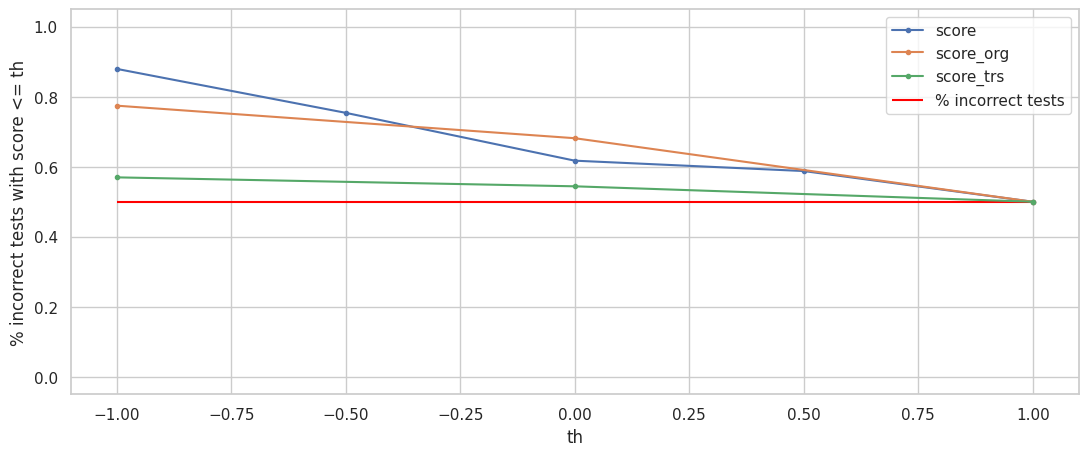

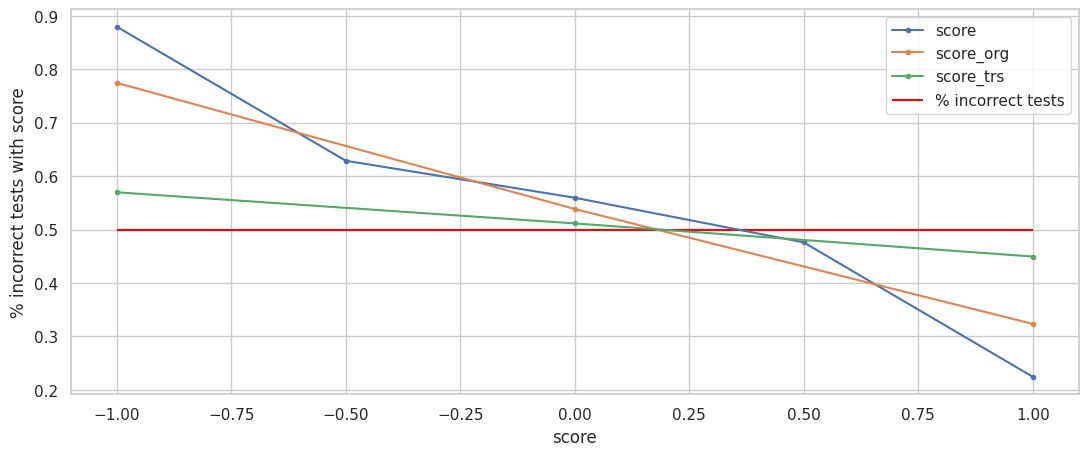

0.35656836461126007


Text(0.5, 1.0, 'Correlation btw score and Doc_length')

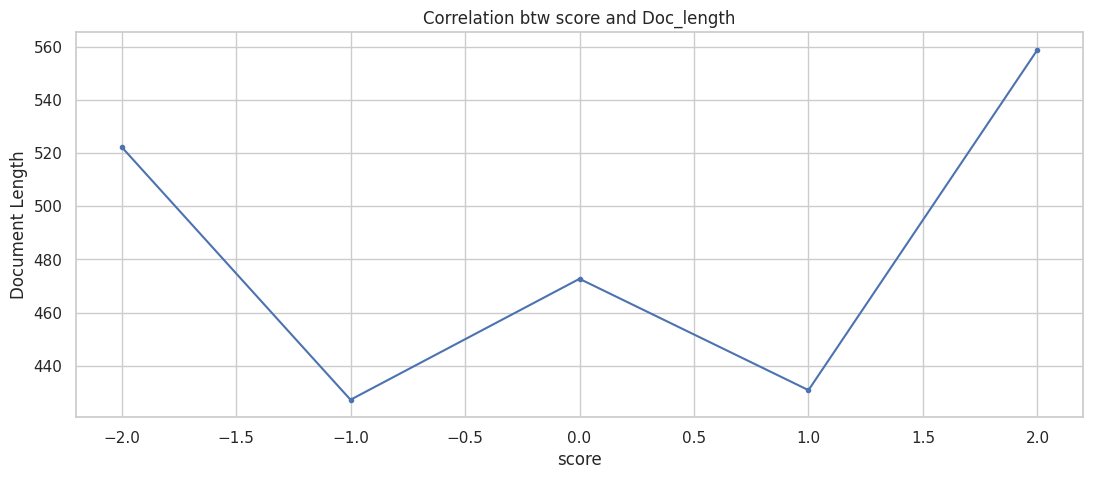

In [ ]:
fail_df["score"] = fail_df.score_org + fail_df.score_trs
pass_df["score"] = pass_df.score_org + pass_df.score_trs

pred_df = pd.concat([fail_df, pass_df])
prediction_columns = ["score", "score_org", "score_trs"]
plt.figure(figsize=(13, 5))
for i, col in enumerate(prediction_columns):
    # plt.subplot(1, len(prediction_columns), i+1)
    thresholds = range(pred_df[col].min(), pred_df[col].max() +1)
    incorrect_ratio = [(pred_df[pred_df[col] <= score].ground_truth == "incorrect").mean() for score in thresholds]
    scores = [ 2 * th /(max(thresholds) - min(thresholds)) for th in thresholds]
    # #scores = [ th for th in thresholds]
    plt.plot(scores, incorrect_ratio, marker=".", label=col)

plt.hlines((pred_df.ground_truth == "incorrect").mean(), min(scores), max(scores), color="red", label="% incorrect tests")
plt.xlabel("th")
plt.ylabel("% incorrect tests with score <= th")
plt.legend()
plt.ylim((-0.05, 1.05))
plt.show()


number_of_test_df = pd.DataFrame()
plt.figure(figsize=(13, 5))
for i, col in enumerate(prediction_columns):
    number_of_test_df[f'{col}_failing_test'] = fail_df[col].value_counts()
    number_of_test_df[f'{col}_passing_test'] = pass_df[col].value_counts()
    number_of_test_df.fillna(0, inplace=True)

    thresholds = range(pred_df[col].min(), pred_df[col].max() +1)
    failing_ratio =  [number_of_test_df.loc[score, f'{col}_failing_test'] / (number_of_test_df.loc[score, f'{col}_failing_test'] + number_of_test_df.loc[score, f'{col}_passing_test']) for score in thresholds]
    scores = [ 2 * th /(max(thresholds) - min(thresholds)) for th in thresholds]
    plt.plot(scores, failing_ratio, marker=".", label=col)
    
plt.hlines((pred_df.ground_truth == "incorrect").mean(), min(scores), max(scores), color="red", label="% incorrect tests")
plt.xlabel("score")
plt.ylabel("% incorrect tests with score")
plt.legend()
plt.show()


# rat_rows_precision = []
# for org_score in range(-5, 6):
#     for trs_score in range(-5, 6):
#         # True Positives (TP): Ground truth is "incorrect" and predicted as "incorrect"
#         TP = ((pred_df.score_org <= org_score) & (pred_df.score_trs <= trs_score) & (pred_df.ground_truth == "incorrect")).sum()
#         # False Positives (FP): Ground truth is "correct" but predicted as "incorrect"
#         FP = ((pred_df.score_org <= org_score) & (pred_df.score_trs <= trs_score) & (pred_df.ground_truth == "correct")).sum()
#         # Calculate precision
#         precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#         rat_rows_precision.append((org_score, trs_score, precision))

# # Create precision dataframe and heatmap
# plt.figure(figsize=(10, 10))
# rat_df_precision = pd.DataFrame(data=rat_rows_precision, columns=["org_th", "trs_th", "precision"]).pivot("org_th", "trs_th", "precision")
# sns.heatmap(rat_df_precision, annot=True, fmt=".2f", cmap="Reds")
# plt.xlabel("Threshold for Transformation Score")
# plt.ylabel("Threshold for Original Score")
# plt.title("Precision Heatmap")
# plt.show()

# Recall 
total_incorrect = (pred_df.ground_truth == "incorrect").sum()
print((pred_df.score < 0).sum()/ total_incorrect)
plt.figure(figsize=(13, 5))

score_doclen = []
for score in range(-10, 11):
    document_length = pred_df[pred_df.score == score].document_length.mean()
    score_doclen.append((score, document_length))
score_doclen_df = pd.DataFrame(data=score_doclen, columns=["score","doc_leng"])
plt.plot(score_doclen_df["score"],score_doclen_df["doc_leng"], marker=".")
plt.xlabel("score")
plt.ylabel("Document Length")
plt.title("Correlation btw score and Doc_length")



PearsonRResult(statistic=0.36127475713857654, pvalue=8.973427015193387e-161)

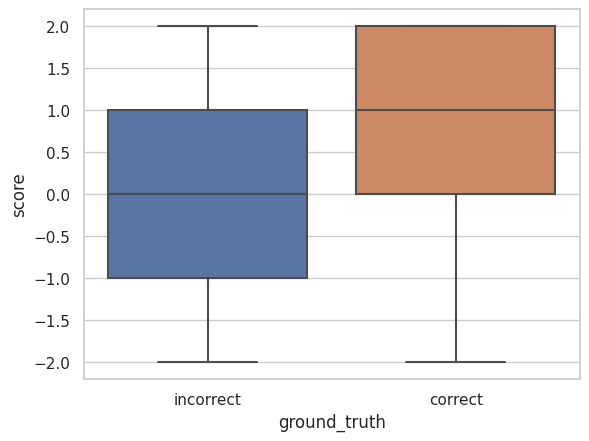

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')
pred_df

pred_df["is_correct"] = pred_df["ground_truth"] == "correct"
sns.boxplot(data=pred_df, x="ground_truth", y="score")


from scipy.stats import pearsonr

pearsonr(pred_df["is_correct"], pred_df["score"]) # point - biserial correlation coefficient


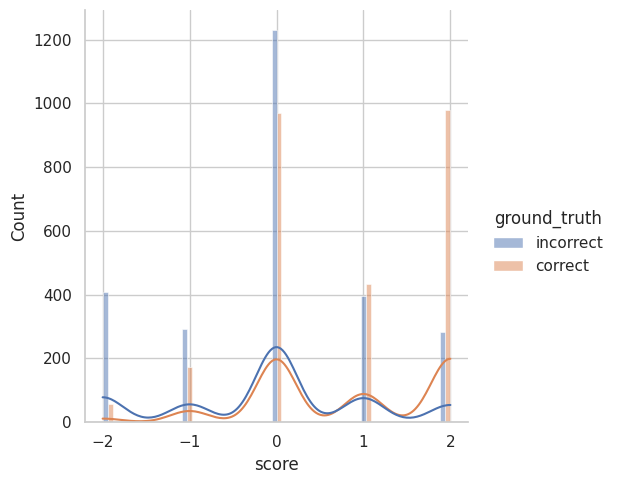

In [ ]:

sns.displot(data=pred_df, hue="ground_truth", x="score", kde=True, multiple='dodge')


In [ ]:
def count_occurrences(attempt_list, label):
    return attempt_list.count(label)

project = "Lang"
version = "1"
ts_id = "newTS_300"
example_num = 0

dfs = []
for prompt_no in [8, 9, 10 ,11]:
    fail_df, pass_df = get_fail_pass_df(project, version, ts_id, prompt_no, example_num, is_conv = True)
    fail_df["score"] = fail_df.score_org + fail_df.score_trs
    pass_df["score"] = pass_df.score_org + pass_df.score_trs
    pred_df = pd.concat([fail_df, pass_df])
    labels = ["correct", "undecidable", "incorrect"]
    pred_df_trys = pred_df.loc[:,["attempt_org", "attempt_trs"]]
    for label in labels:
        pred_df[f"attempt_org_{label}_cnt"] = pred_df_trys["attempt_org"].apply(lambda x: count_occurrences(x, label))
        pred_df[f"attempt_trs_{label}_cnt"] = pred_df_trys["attempt_trs"].apply(lambda x: count_occurrences(x, label))

    pred_df.loc[pred_df["ground_truth"]=="incorrect",["label"]] = 1
    pred_df.loc[pred_df["ground_truth"]=="correct",["label"]] = 0
    dfs.append(pred_df)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

for i, df in enumerate(dfs):
    pred_scores = df.score_org + df.score_trs
    suspiciousness = -(pred_scores - pred_scores.min())/(pred_scores.max() - pred_scores.min()) # 0 ~ 1
    fprs, tprs, thresholds = roc_curve(df.label.astype(bool), suspiciousness)
    pre, rec,th = precision_recall_curve(df.label.astype(bool), suspiciousness)
    print('roc_acut_score:', roc_auc_score(df.label.astype(bool), suspiciousness))
    #plt.plot(fprs, tprs, label = f'prompt_{i+1}')
    plt.plot(rec, pre, label = f'prompt_{i+1}')



plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve")
plt.legend()



TypeError: get_fail_pass_df() missing 1 required positional argument: 'sample_num'

### (deprecated) Document length

In [ ]:
# length = {}
# for score in range(pred_df["Predict"].min(), pred_df["Predict"].max() + 1):
#     length[score]=pred_df[pred_df["Predict"]==score].document_length.mean()

# result = pd.Series(data= length ).to_frame().rename(columns={"0":"length"})

# result.rename(columns={0:"length"}, inplace=True)
# result
# plt.title("Correlation btw documnet_length and prediction score")
# plt.plot(result.index, result.length)

0.7099256219543473
2468    0.8
1579    0.5
182     0.6
2353    0.9
2467    1.0
       ... 
230     0.4
251     0.4
448     0.5
2578    0.6
1763    0.9
Length: 1300, dtype: float64


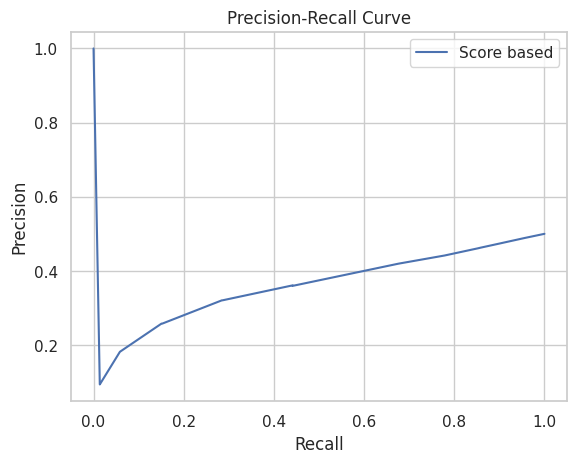

In [ ]:
pred_df.loc[pred_df["ground_truth"]=="incorrect",["label"]] = 1 
pred_df.loc[pred_df["ground_truth"]=="correct",["label"]] = 0

def score_org(attempt_list):
    score = 0
    for reply in attempt_list:
        if reply == "correct":
            score += 1
        elif reply == "incorrect":
            score -= 1
        elif reply == "undecidable":
            score += 0
        else: 
            score += 0
    return score

def count_occurrences(attempt_list, label):
    return attempt_list.count(label)

labels = ["correct", "undecidable", "incorrect"]
pred_df_trys = pred_df.loc[:,["attempt_org", "attempt_trs"]]
for label in labels:
    pred_df[f"attempt_org_{label}_cnt"] = pred_df_trys["attempt_org"].apply(lambda x: count_occurrences(x, label))
    pred_df[f"attempt_trs_{label}_cnt"] = pred_df_trys["attempt_trs"].apply(lambda x: count_occurrences(x, label))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc
X_train, X_test, y_train, y_test = train_test_split(pred_df[["score_org", "score_trs"]], pred_df["label"], test_size=0.25, stratify=pred_df["label"])

scaler = MaxAbsScaler()
s_X_train = scaler.fit_transform(X_train)
model = LogisticRegression(class_weight="balanced")

model.fit(s_X_train,y_train)

print(model.score(s_X_train, y_train))

# y_pred = model.predict(scaler.transform(X_test))
# #print(y_test.mean(), precision_score(y_true=y_test, y_pred=y_pred), recall_score(y_true=y_test, y_pred=y_pred))
# prec, rec, thresholds = precision_recall_curve(y_test, y_pred)
# #print(auc(rec, prec))
# plt.plot(rec, prec, label = 'Logistic Regression')

pred_scores = X_test.score_org + X_test.score_trs
suspiciousness = (pred_scores - pred_scores.min())/(pred_scores.max() - pred_scores.min()) # 0 ~ 1
print(suspiciousness)
prec, rec, thresholds = precision_recall_curve(y_test.astype(bool), suspiciousness)
# print(thresholds)
# print(auc(rec, prec))
plt.plot(rec, prec, label = "Score based")
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title("Precision-Recall Curve")
plt.legend()

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MaxAbsScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, roc_curve

# X_train, X_test, y_train, y_test = train_test_split(pred_df[["attempt_org_correct_cnt", "attempt_org_undecidable_cnt", "attempt_org_incorrect_cnt", "attempt_trs_correct_cnt", "attempt_trs_undecidable_cnt", "attempt_trs_incorrect_cnt"]], pred_df["label"], test_size=0.25, stratify=pred_df["label"])
# scaler = MaxAbsScaler()
# s_X_train = scaler.fit_transform(X_train)

# model = LogisticRegression(class_weight="balanced")
# model.fit(s_X_train,y_train)
# y_pred = model.predict(scaler.transform(X_test))

# print("model.score:",model.score(s_X_train, y_train))
# print(precision_score(y_true=y_test, y_pred=y_pred), recall_score(y_true=y_test, y_pred=y_pred))
# prec, rec, thresholds = precision_recall_curve(y_test, y_pred)
# print(prec, rec, thresholds)
# print(auc(rec, prec))
# plt.title("recall_precision curve")
# plt.plot(rec, prec)
